In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tf.test.is_gpu_available()



urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")



total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])



total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)



total_data.drop_duplicates(subset=['reviews'], inplace=True)



# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)



# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)



# 중복 제거
test_data.drop_duplicates(subset = ['reviews'], inplace=True) 
# 정규 표현식 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
# 공백은 Null 값으로 변경
test_data['reviews'].replace('', np.nan, inplace=True) 
# Null 값 제거
test_data = test_data.dropna(how='any') 



from eunjeon import Mecab
mecab = Mecab()



stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']



train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])



X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values



# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 텍스트 데이터에 정수 인코딩 수행

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)



# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수 부여
# 등장 횟수가 1회인 단어들은 자연어 처리에서 배제

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



# 단어 집합 크기를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)



tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



# 패딩
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 작업

def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))



max_len = 80
below_threshold_len(max_len, X_train)



# 훈련용 리뷰의 99.99가 80이하의 길이를 가지기 때문에, 훈련용 리뷰를 길이 80으로 패딩

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)



# GRU로 네이버 쇼핑 리뷰 감성 분류

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
    
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)



loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))



def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))



sentiment_predict("불친절")



data = pd.read_csv('D:\polo_main.csv')



data

C:\Users\jeonj\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


C:\Users\jeonj\AppData\Local\Temp\ipykernel_15440\1071252944.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\jeonj\AppData\Local\Temp\ipykernel_15440\1071252944.py:51: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495
단어 집합의 크기 : 21687
전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553
Epoch 1/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2705 - acc: 0.8984
Epoch 1: val_acc improved from -inf to 0.91743, saving model to best_model.h5
1875/1875 [==============================] - 43s 18ms/step - loss: 0.2704 - acc: 0.8985 - val_loss: 0.2264 - val_acc: 0.9174
Epoch 2/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.9223
Epoch 2: val_acc improved from 0.91743 to 0.92257, saving model to best_model.h5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2147 - acc: 0.9223 - val_loss: 0.2137 - val_acc: 0.9226
Epoch 3/15
1873/1875 [============================>.] - ETA: 0s - loss: 0.1984 - acc: 0.9292
Epoch 3: val_acc improved from 0.92257 to 0.92687, saving model to best_model.h5
1875/1875 [==============

,Unnamed: 0,comment,star,date
0,1,163/53 m 사이즈 딱 맞아요! 핏되게 입는 거 좋아하시면 사세요. 라지는 팔 ...,5,2022-06-16
1,2,흰색말고 원색컬러 티셔츠 구매하고싶어서 샀어요!ㅎㅎ 면은 정말 좋고 배송도 나름 빨...,5,2022-07-14
2,3,올이 다 풀려버렸습니다. 박음질 자체가 이상해요. 다른데서 구매한 건 이렇지 않았는...,1,2022-07-06
3,4,"일요일에 주문했는데 목요일 아침에 도착했어요ㅎ 재질도 좋고 약간 루즈핏 원했는데 ,...",5,2022-07-14
4,5,L가 품절이라 혹시나 해서 m 샀는데 좀 타이트하네여 남자 s 사이즈엔 m은 좀 타...,5,2022-07-15
...,...,...,...,...
10833,10834,Xogko ogcocog hogo i,5,2018-07-16
10834,10835,Xypxcochohcocco k kh llh,5,2018-07-16
10835,10836,좋아요~~~~,5,2018-06-18
10836,10837,좋아요 \nM 샀다가 너무 딱 맞아서 \nXl 샀는데 편하게 잘 입네요*^,5,2022-05-13


In [9]:
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm

In [2]:
print(data.isnull().values.any())

False


In [3]:
data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\jeonj\AppData\Local\Temp\ipykernel_15440\1634925288.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['comment'] = data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [4]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [14]:
data['comment']

0          사이즈 딱 맞아요 핏되게 입는 거 좋아하시면 사세요 라지는 팔 길이가 길어 보이...
1        흰색말고 원색컬러 티셔츠 구매하고싶어서 샀어요ㅎㅎ 면은 정말 좋고 배송도 나름 빨랐...
2        올이 다 풀려버렸습니다 박음질 자체가 이상해요 다른데서 구매한 건 이렇지 않았는데 ...
3        일요일에 주문했는데 목요일 아침에 도착했어요ㅎ 재질도 좋고 약간 루즈핏 원했는데 원...
4        가 품절이라 혹시나 해서  샀는데 좀 타이트하네여 남자  사이즈엔 은 좀 타이틀하게...
                               ...                        
10833                                                     
10834                                                     
10835                                                  좋아요
10836                     좋아요  샀다가 너무 딱 맞아서  샀는데 편하게 잘 입네요
10837      배송이 너무 빨라서 좋았습니다색상이 너무 예쁩니다구하기 힘든 색상이라 너무 만족합니다
Name: comment, Length: 10838, dtype: object

In [16]:
tokenized_data = []
for sentence in tqdm(data['comment']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████████████| 10838/10838 [00:00<00:00, 16324.47it/s]


리뷰의 최대 길이 : 375
리뷰의 평균 길이 : 13.168389001660824


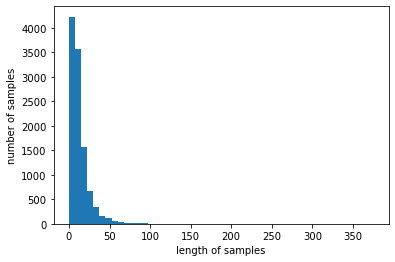

In [18]:
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [24]:
model.wv.vectors.shape

(1502, 100)

In [34]:
print(model.wv.most_similar("추천"))

[('전체', 0.8859522938728333), ('당', 0.8825482726097107), ('적', 0.8796529769897461), ('수고', 0.8729549050331116), ('드립니다', 0.8721521496772766), ('드려요', 0.8706172108650208), ('드리', 0.8696132302284241), ('단정', 0.86883944272995), ('당해', 0.8673174977302551), ('편한', 0.8663418292999268)]
